In [3]:
!pip install tensorflow==2.1

  Using cached https://files.pythonhosted.org/packages/35/55/a0dbd642e68e68f3e309d1413abdc0a7aa7e1534c79c0fc2501defb864ac/tensorflow-2.1.0-cp37-cp37m-macosx_10_11_x86_64.whl
     |████████████████████████████████| 3.9MB 662kB/s
  Using cached https://files.pythonhosted.org/packages/18/90/b77c328a1304437ab1310b463e533fa7689f4bfc41549593056d812fab8e/tensorflow_estimator-2.1.0-py2.py3-none-any.whl
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [5]:
from IPython.display import Image
#Image("dqn.png", width=800, height=600)

In [6]:
import gym
import numpy as np
import tensorflow as tf

In [7]:
class MyModel(tf.keras.Model):
    def __init__(self, num_states, hidden_units, num_actions):
        super(MyModel, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
        self.hidden_layers = []
        for i in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(
                i, activation='relu', kernel_initializer='RandomNormal'))
        self.output_layer = tf.keras.layers.Dense(
            num_actions, activation='linear', kernel_initializer='RandomNormal')

    @tf.function
    def call(self, inputs):
        z = self.input_layer(inputs)
        for layer in self.hidden_layers:
            z = layer(z)
        output = self.output_layer(z)
        return output

class MemoryBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, 1], dtype=np.int32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs.flatten()
        self.obs2_buf[self.ptr] = next_obs.flatten()
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=self.obs1_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])
        
def train(Q_main, Q_targ, gamma, buffer, batch_size, optimizer):
  batch = buffer.sample_batch(batch_size)
  o = batch['obs1']
  a = batch['acts'].flatten()
  r = batch['rews']
  o2 = batch['obs2']
  d = batch['done']

  states = np.asarray([x for x in o])
  actions = np.asarray([x for x in a])
  rewards = np.asarray([x for x in r])
  states_next = np.asarray([x for x in o2])
  dones = np.asarray([x for x in d])
  value_next = np.max(Q_targ.predict(states_next), axis=1)
  actual_values = np.where(dones, rewards, rewards+gamma*value_next)

  with tf.GradientTape() as tape:
      xx = Q_main(np.atleast_2d(states.astype('float32')))
      selected_action_values = tf.math.reduce_sum(xx * tf.one_hot(actions, 2), axis=1)
      loss = tf.math.reduce_sum(tf.square(actual_values - selected_action_values))
  variables = Q_main.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

def sync_weights(Q_main, Q_target):
  variables1 = Q_target.trainable_variables
  variables2 = Q_main.trainable_variables
  for v1, v2 in zip(variables1, variables2):
      v1.assign(v2.numpy())

In [ ]:
# Define env
env = gym.make('CartPole-v0')

# MODEL PARAMETERS
hidden_dims = [64,64]
hidden_activations = ['relu', 'relu']
gamma = 0.99
lr = 1e-3
epsilon = 1.0
min_epsilon = 0.1
epsilon_decay = 0.9
copy_step = 20
batch_size = 100

# TRAINING PARAMETERS
num_episodes = 65
max_steps = 200
min_experiences = 100
max_experiences = 2000

# MODELS, OPTIMIZER & LOSS
Q_main = MyModel(num_states=4, hidden_units=[64,64], num_actions=2)
Q_targ = MyModel(num_states=4, hidden_units=[64,64], num_actions=2)
optimizer = tf.optimizers.Adam(lr)

# memory buffer 
buffer = MemoryBuffer(env.observation_space.shape[0], env.action_space.n, max_experiences)

# Metrics
all_rewards = []

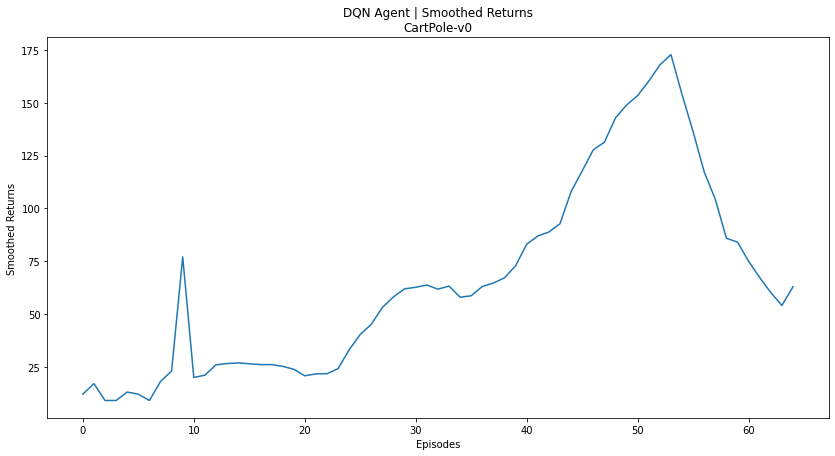

In [16]:
#!pip install matplotlib
import matplotlib.pyplot as plt
smooth_returns = [r if i<10 else np.mean(all_rewards[i-10:i]) for i, r in enumerate(all_rewards[:400])]
fig, ax = plt.subplots(figsize=(14,7))
ax.set_title("DQN Agent | Smoothed Returns\n{}".format(env.unwrapped.spec.id))
ax.set_xlabel("Episodes")
ax.set_ylabel("Smoothed Returns")
ax.plot(smooth_returns)
plt.savefig("DQN_results.png", dpi=300)